In [1]:
import uhd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

usrp = uhd.usrp.MultiUSRP()

num_samps = 1024  # number of samples received
# center_freq = 2425e6 # Hz
sample_rate = 50e6  # Hz
gain = 60  # dB
Fs = 50e6

collects = 2000
# threshold=.63
bandwidth = 50e6


def receive_iq_data(center_freq):
    usrp.set_rx_rate(sample_rate, 0)
    usrp.set_rx_freq(uhd.libpyuhd.types.tune_request(center_freq), 0)
    usrp.set_rx_agc(True, 0)
    usrp.set_rx_bandwidth(bandwidth, 0)

    # Set up the stream and receive buffer
    st_args = uhd.usrp.StreamArgs("fc32", "sc16")
    st_args.channels = [0]
    metadata = uhd.types.RXMetadata()
    streamer = usrp.get_rx_stream(st_args)
    recv_buffer = np.zeros((1, 1024), dtype=np.complex64)

    # Start Stream
    stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
    stream_cmd.stream_now = True
    streamer.issue_stream_cmd(stream_cmd)

    # Receive Samples
    samples = np.zeros(num_samps, dtype=np.complex64)
    for i in range(num_samps // 1024):
        streamer.recv(recv_buffer, metadata)
        samples[i * 1024 : (i + 1) * 1024] = recv_buffer[0]

    # Stop Stream
    stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont)
    streamer.issue_stream_cmd(stream_cmd)

    # print(len(samples))
    # print(samples[0:10])
    return samples


def calculate_psd(x, center_freq):
    N = 2048
    x = x * np.hamming(len(x))  # apply a Hamming window
    PSD = np.abs(np.fft.fft(x)) ** 2 / (N * Fs)
    PSD_log = 10.0 * np.log10(PSD)
    PSD_shifted = np.fft.fftshift(PSD_log)

    f = np.arange(Fs / -1, Fs, Fs / (N / 2))  # start, stop, step.  centered around 0 Hz
    f += center_freq  # now add center frequency
    # plt.plot(f, PSD_shifted)
    # plt.show()
    return (PSD_shifted, f)


def detect_peaks(x, num_train, num_guard, rate_fa):
    """
    Detect peaks with CFAR algorithm.

    num_train: Number of training cells.
    num_guard: Number of guard cells.
    rate_fa: False alarm rate.
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half

    alpha = num_train * (rate_fa ** (-1 / num_train) - 1)  # threshold factor

    has_peak = np.zeros(num_cells, dtype=bool)
    peak_at = []
    for i in range(num_side, num_cells - num_side):
        if i != i - num_side + np.argmax(x[i - num_side : i + num_side + 1]):
            continue

        sum1 = np.sum(x[i - num_side : i + num_side + 1])
        sum2 = np.sum(x[i - num_guard_half : i + num_guard_half + 1])
        p_noise = (sum1 - sum2) / num_train
        threshold = alpha * p_noise

        if x[i] > threshold:
            return True


def event_detector(PSD, threshold):
    window_size = 64

    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider
    # every window of size 3
    while i < len(PSD) - window_size + 1:

        # Store elements from i to i+window_size
        # in list to get the current window
        window = PSD[i : i + window_size]

        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)
        if window_average > threshold:
            return True
        else:
            i += window_size
            # print(i)

[INFO] [UHD] linux; GNU C++ version 11.2.0; Boost_107400; UHD_4.1.0.5-3


RuntimeError: LookupError: KeyError: No devices found for ----->
Empty Device Address

  0%|          | 0/1000 [00:00<?, ?it/s]

Pass


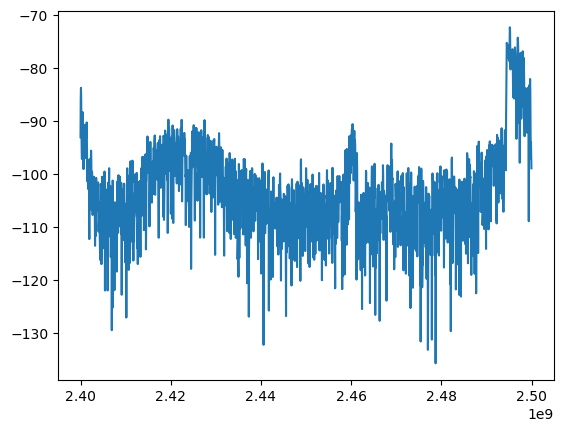

Pass


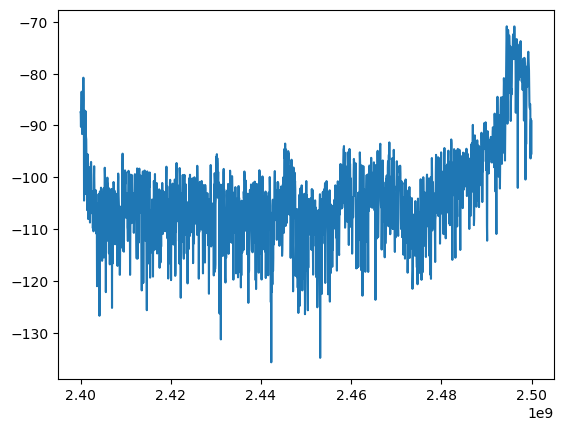

Pass


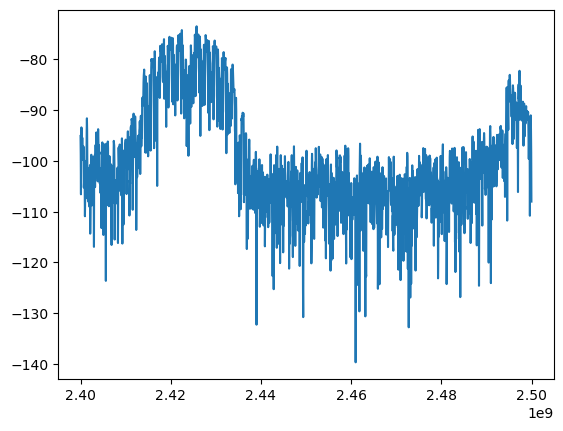

Pass


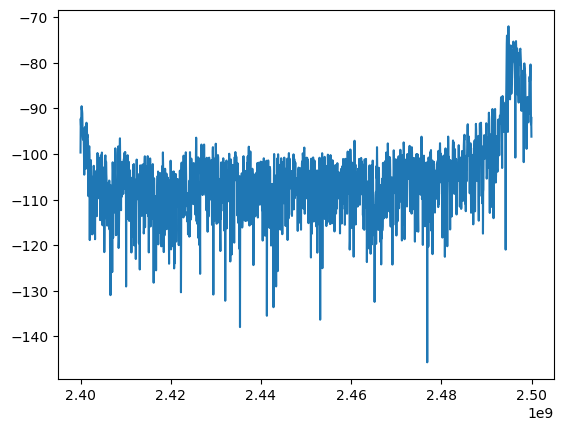

Pass


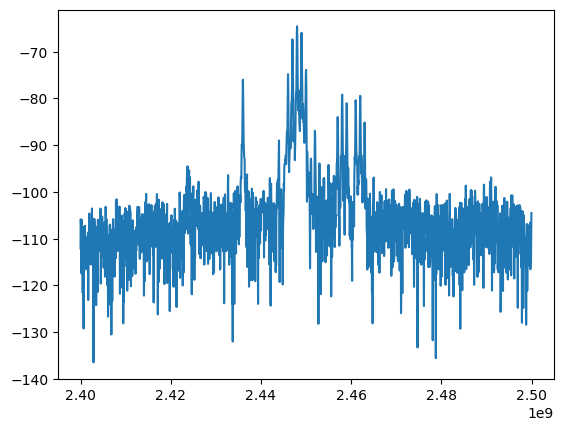

D

Pass


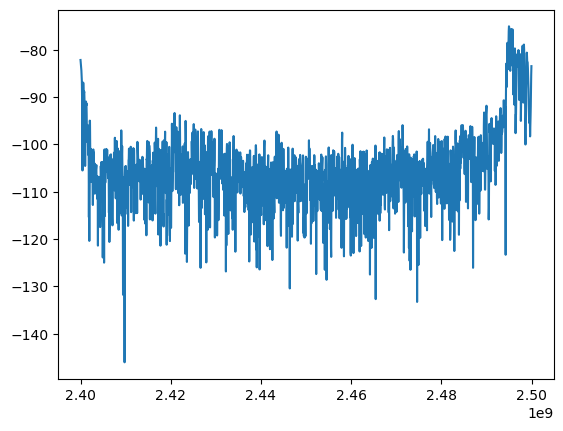

Pass


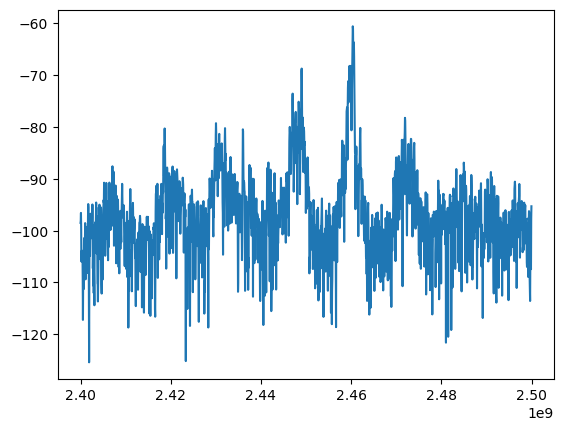

Pass


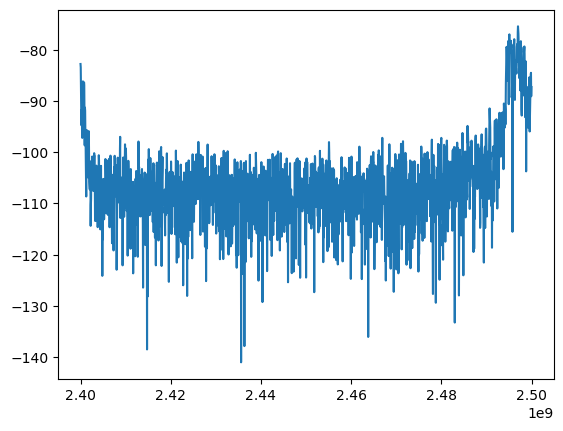

Pass


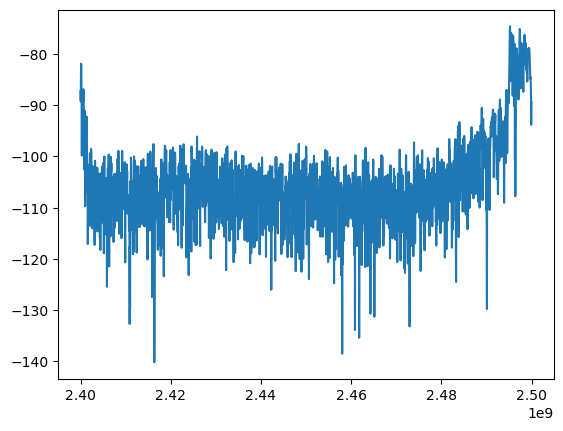

Pass


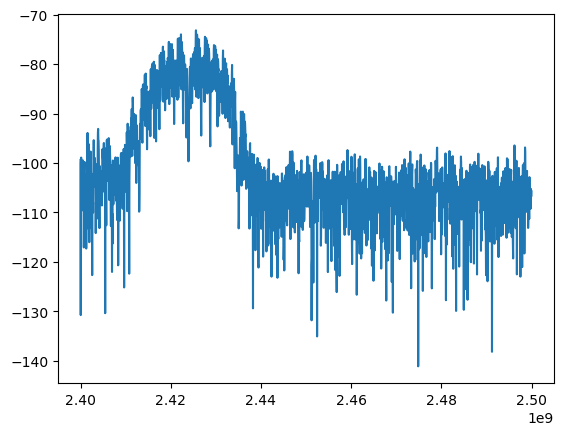

Pass


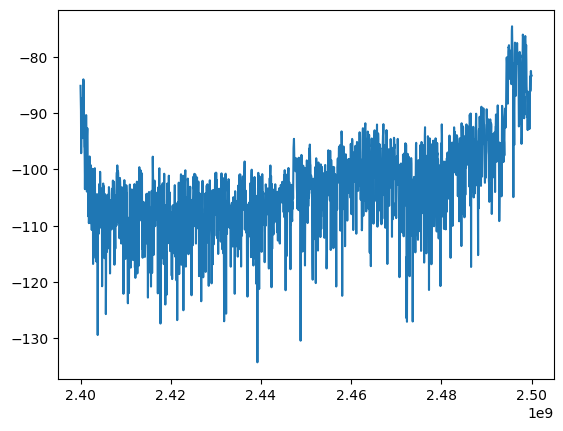

Pass


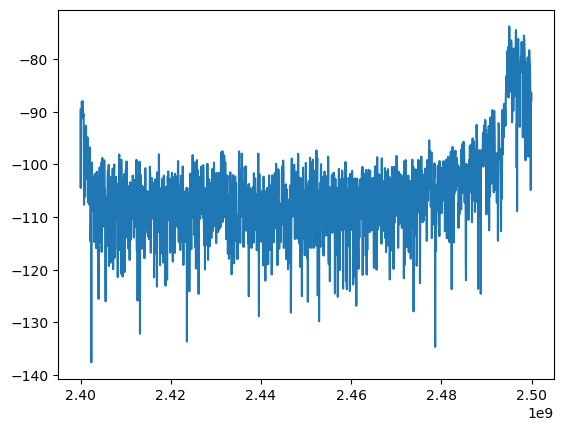

Pass


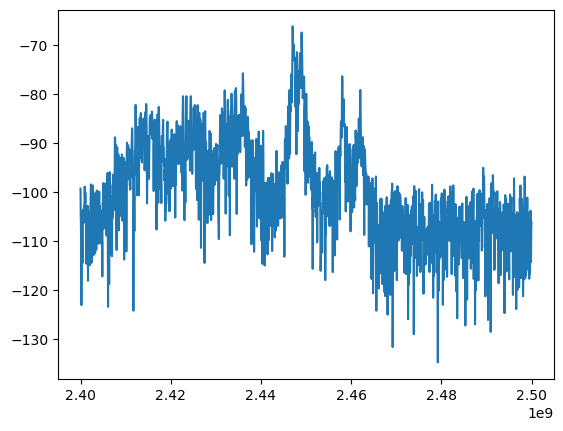

Pass


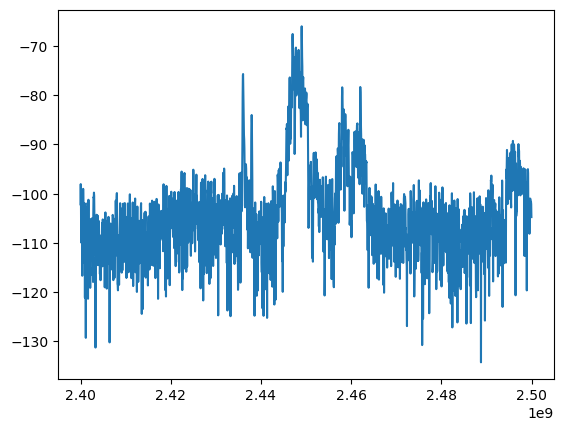

Pass


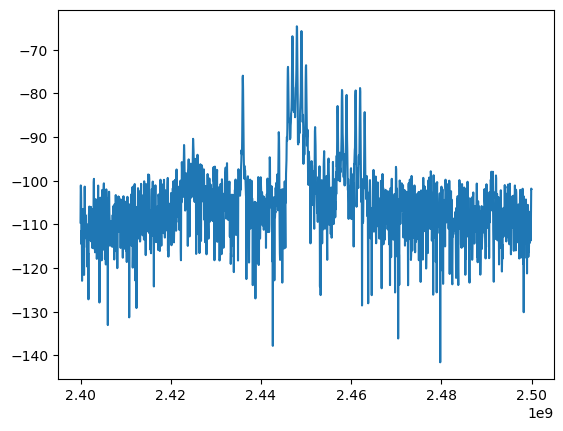

Pass


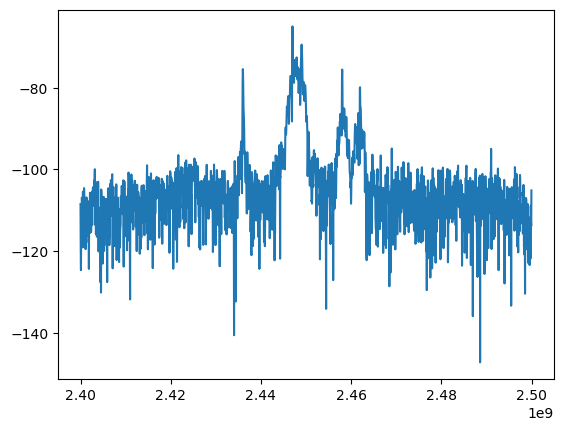

Pass


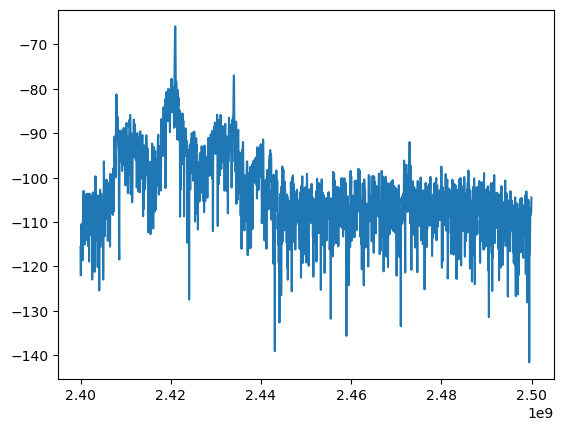

Pass


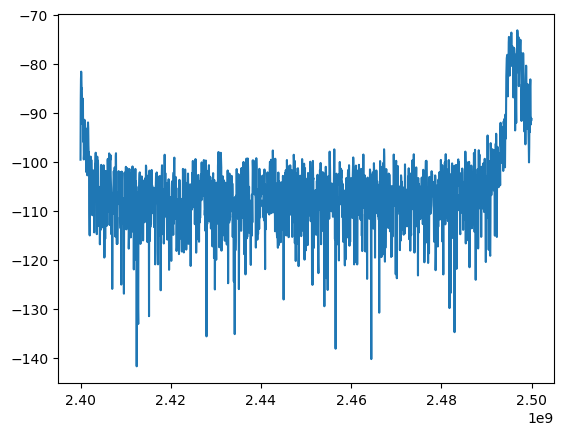

Pass


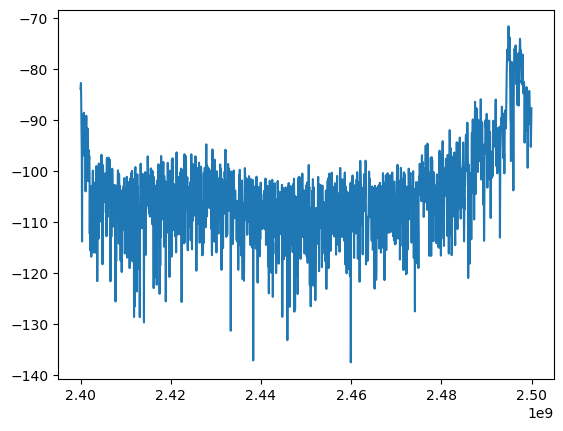

Pass


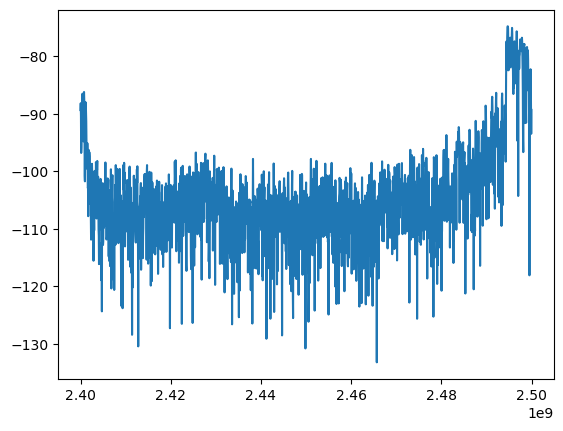

Pass


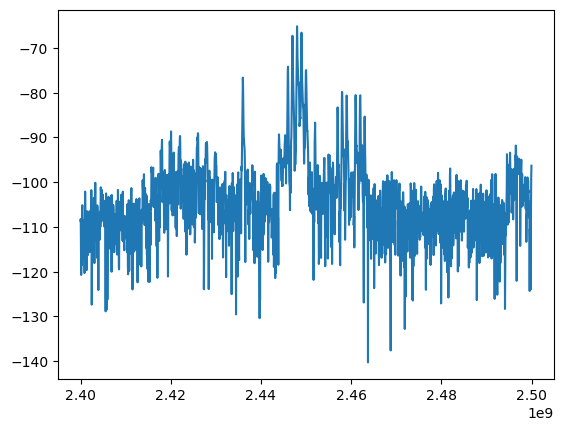

Pass


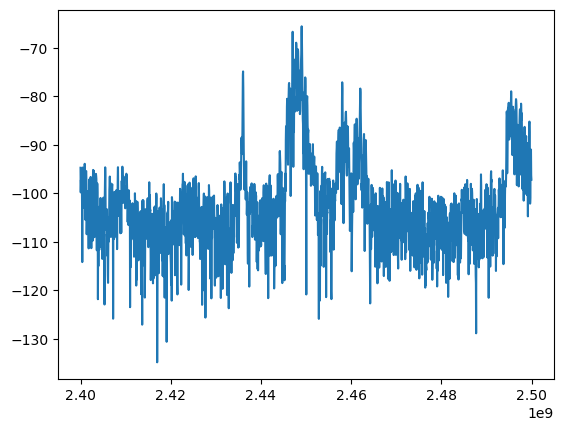

Pass


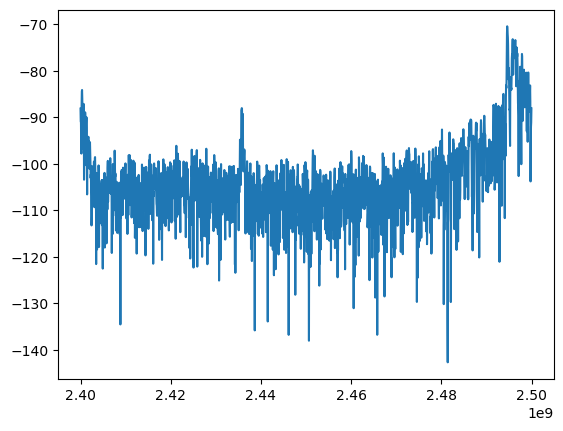

Pass


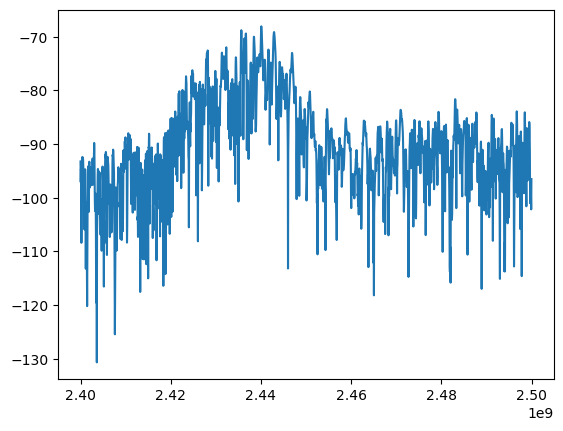

Pass


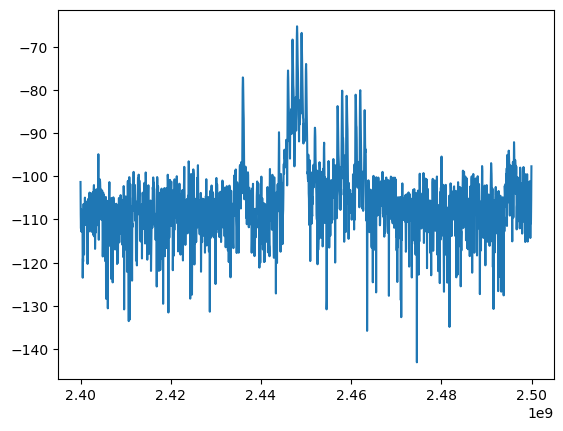

Pass


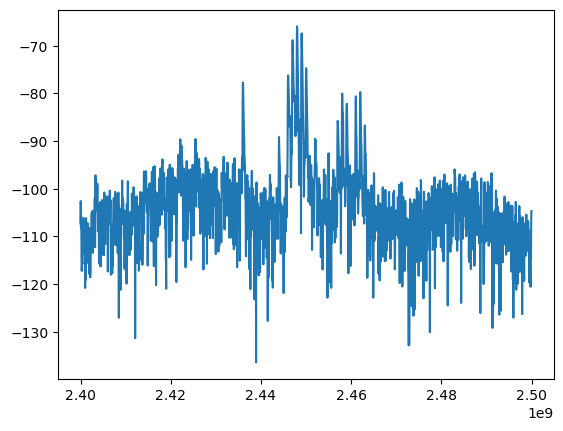

Pass


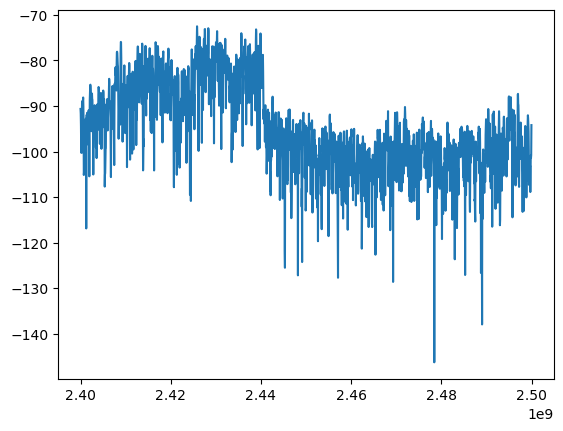

Pass


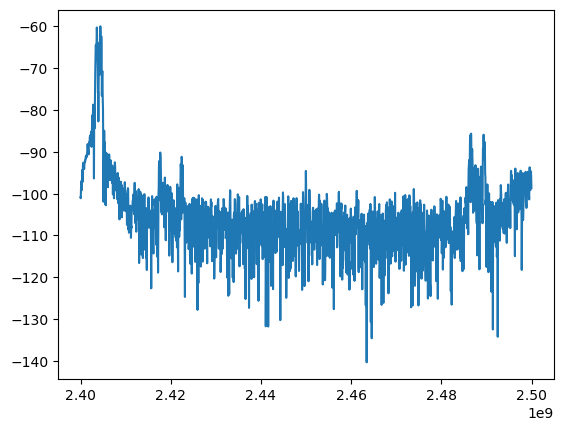

Pass


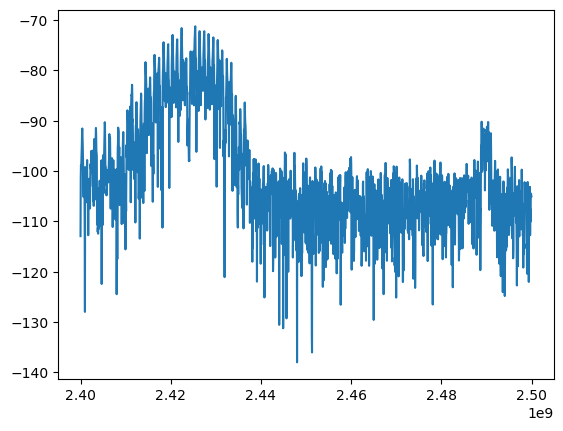

Pass


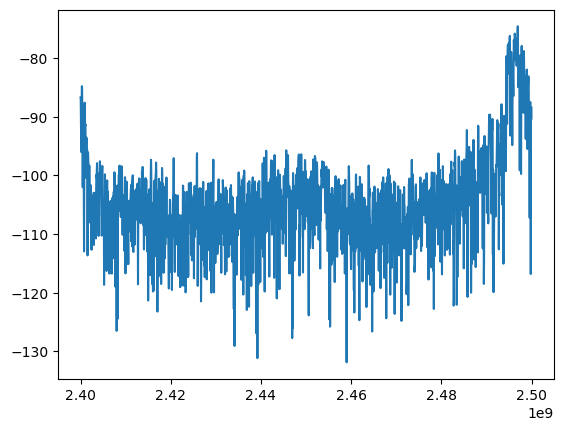

Pass


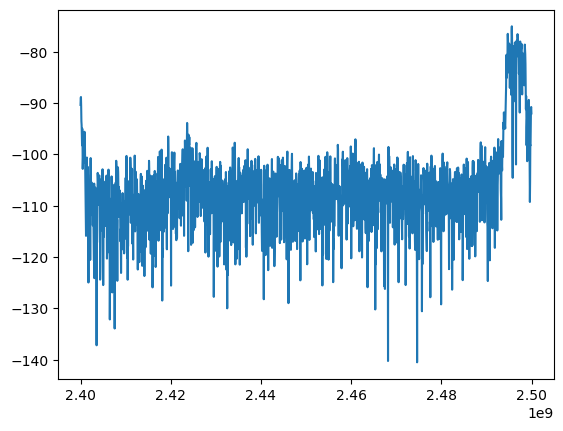

Pass


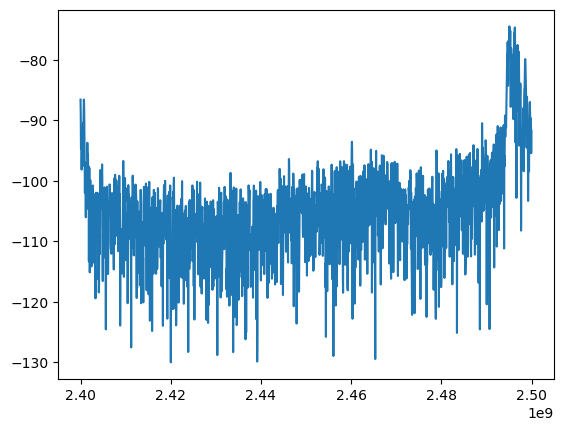

Pass


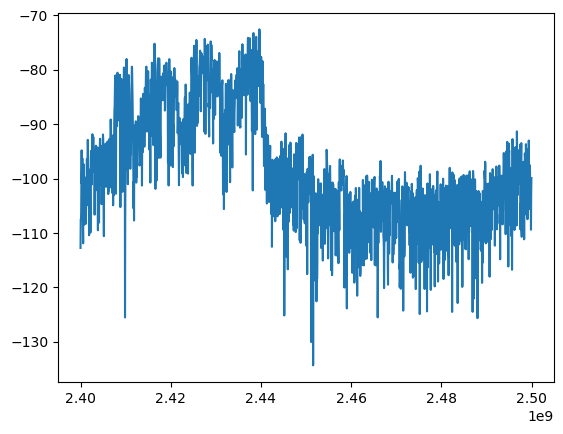

Pass


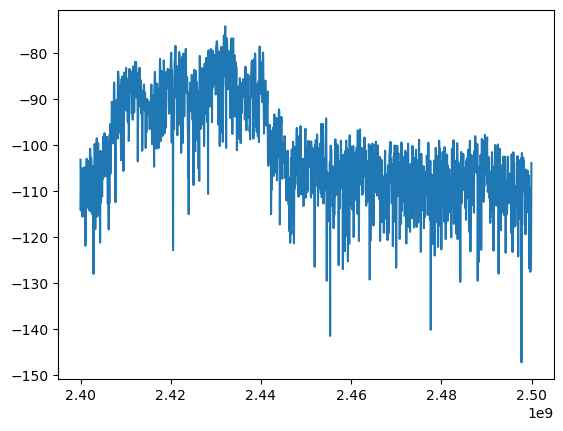

Pass


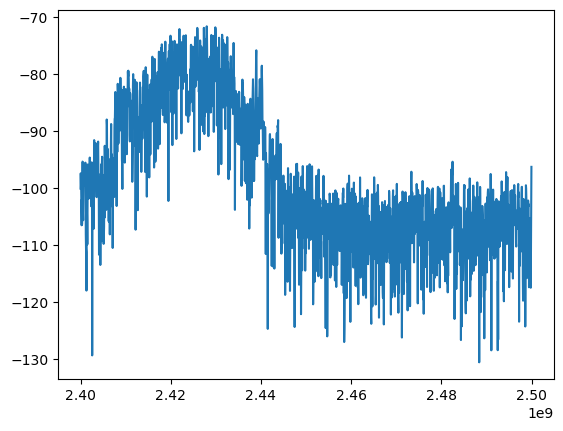

D

Pass


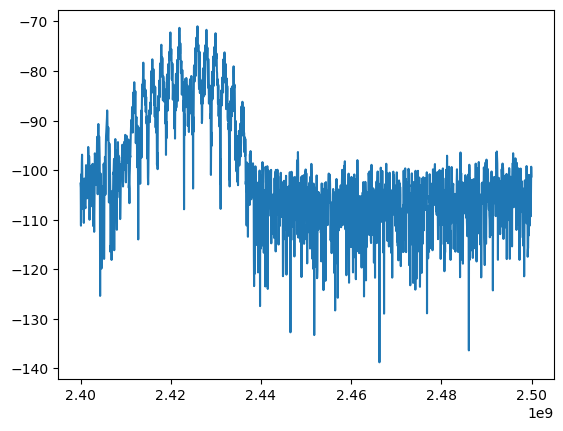

Pass


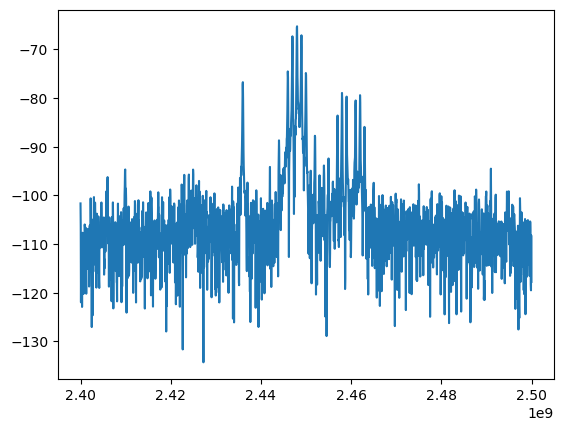

Pass


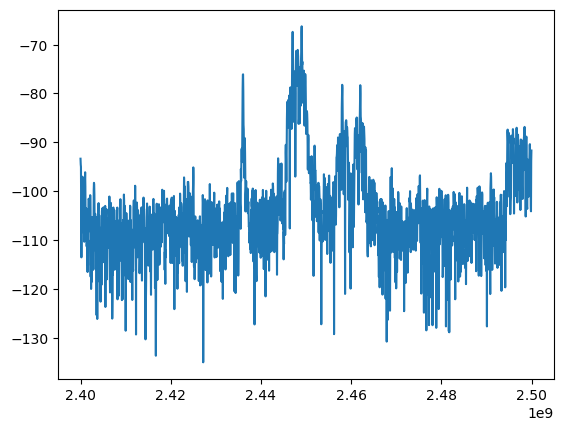

Pass


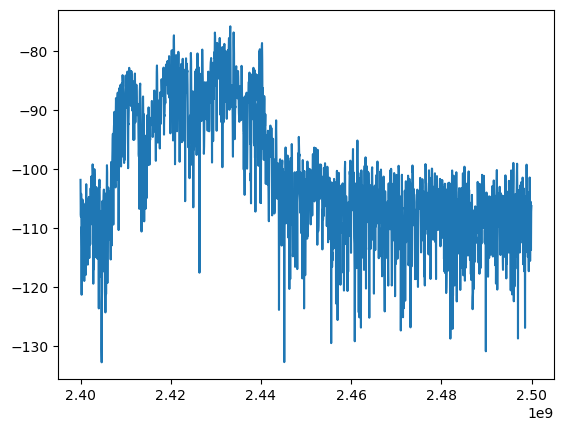

Pass


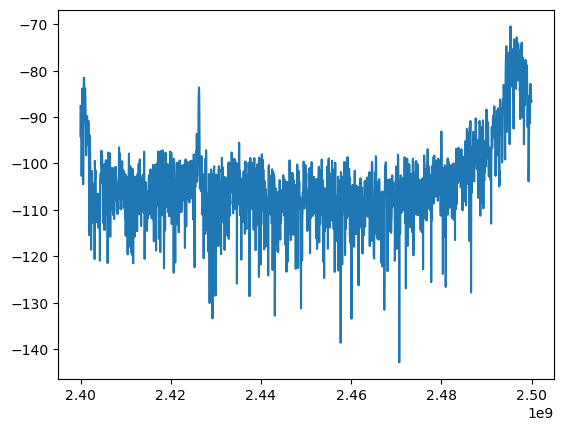

Pass


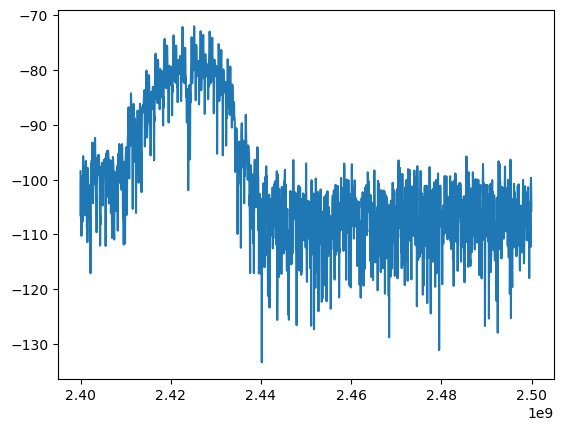

Pass


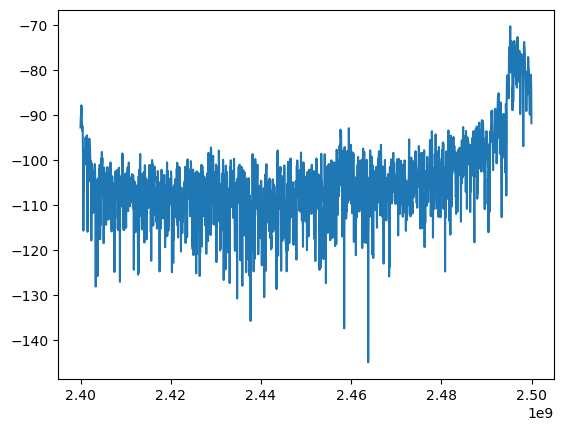

Pass


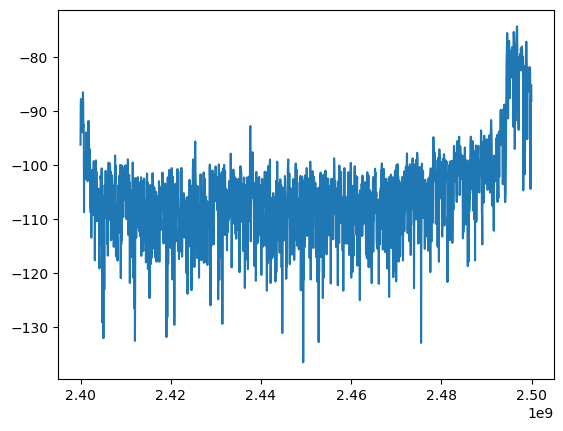

Pass


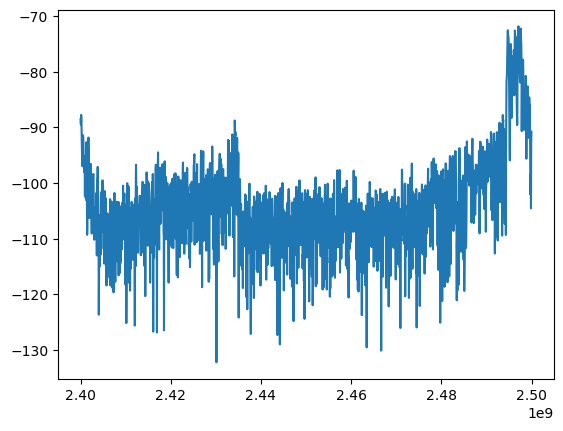

Pass


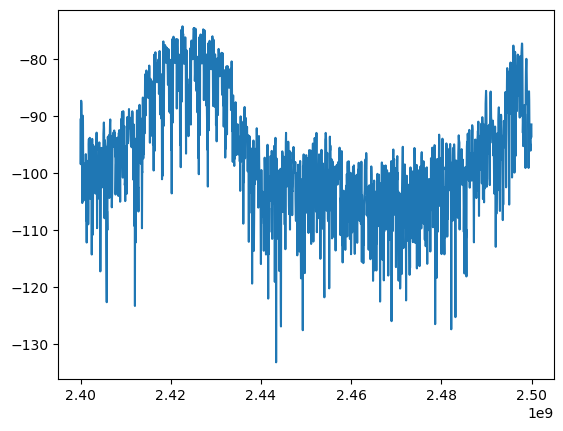

Pass


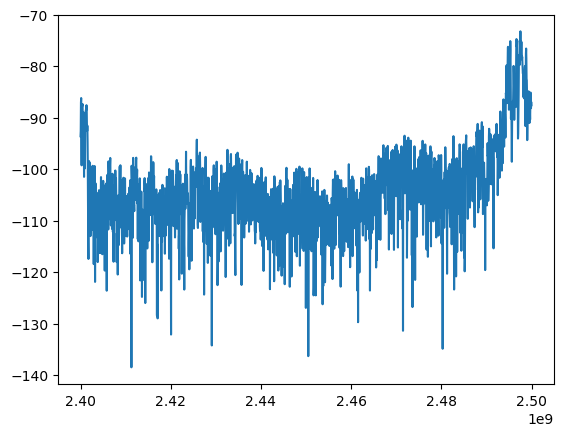

Pass


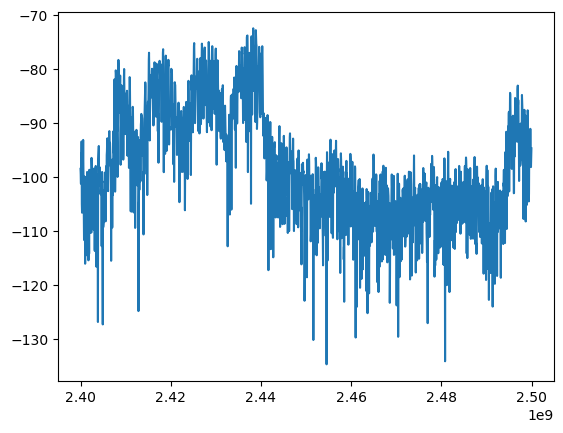

Pass


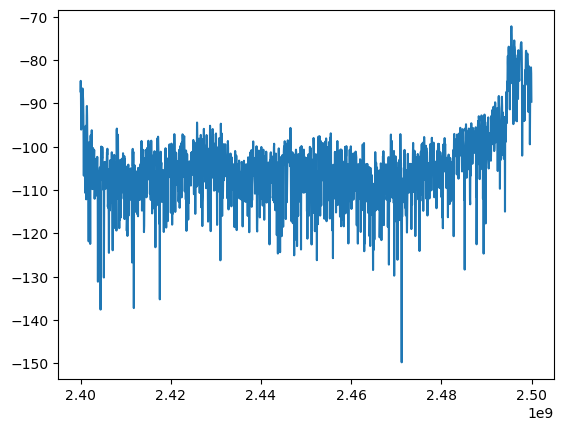

Pass


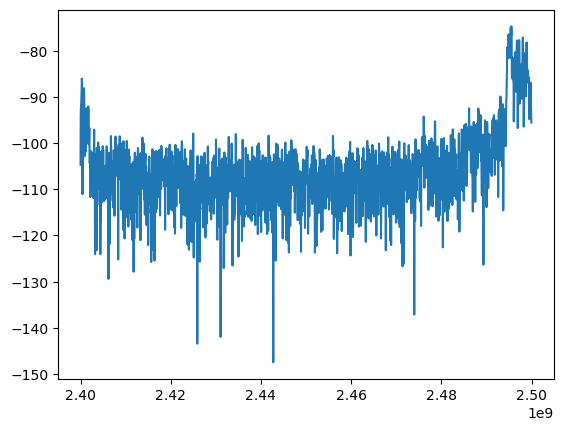

Pass


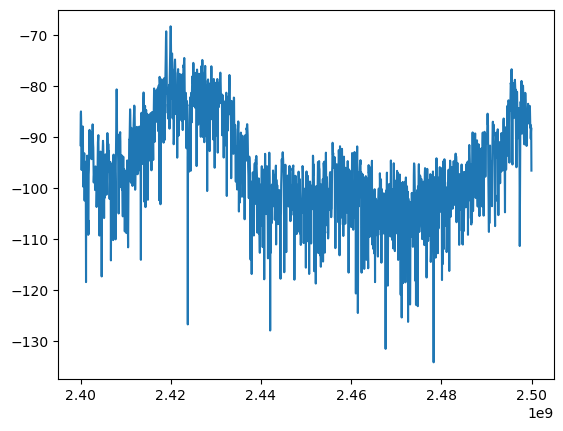

Pass


D

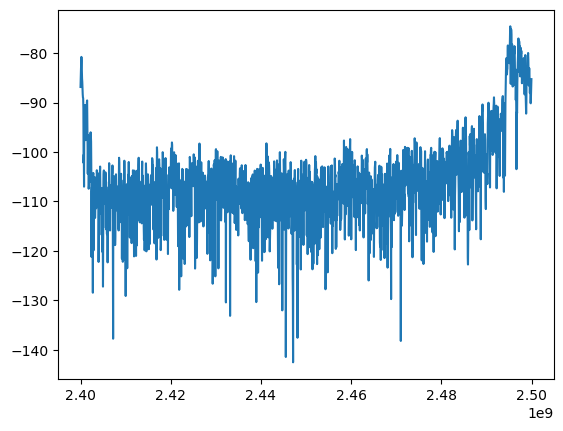

Pass


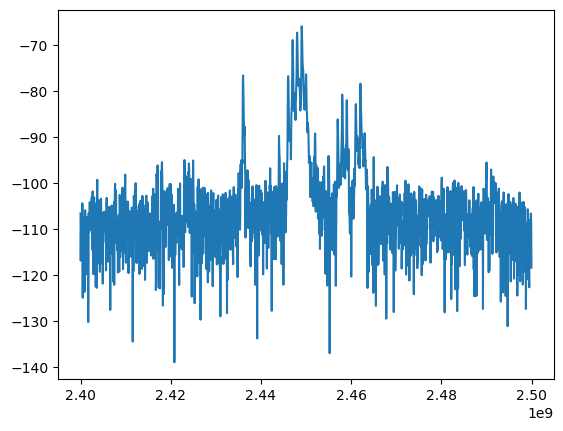

D

Pass


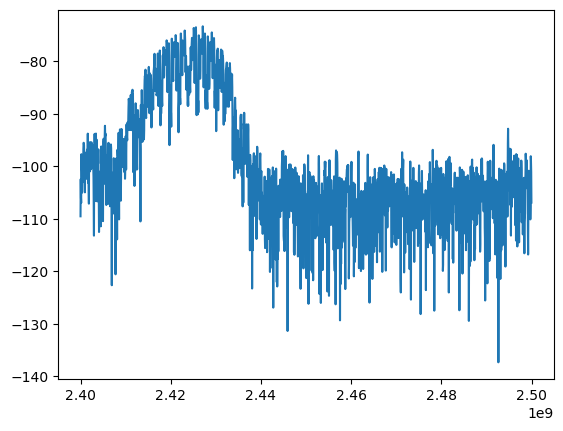

Pass


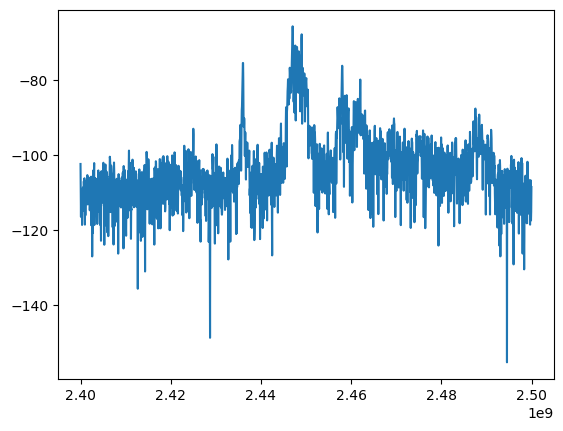

Pass


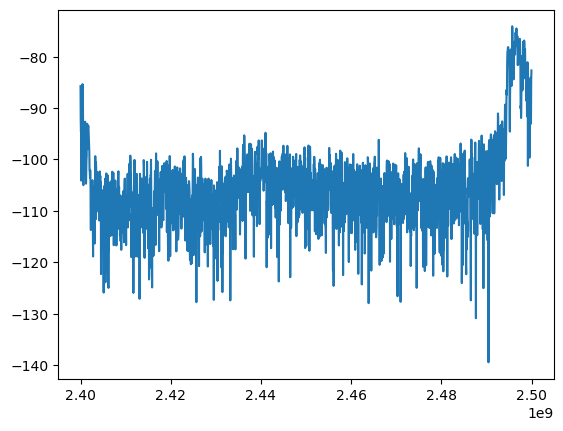

Pass


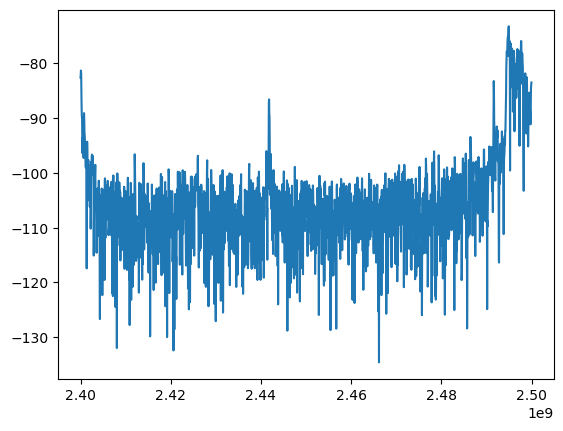

Pass


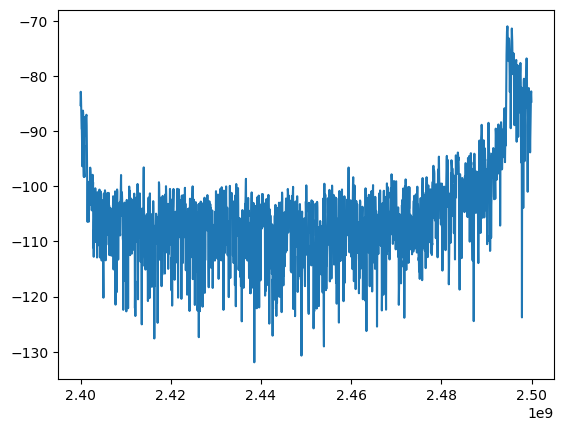

Pass


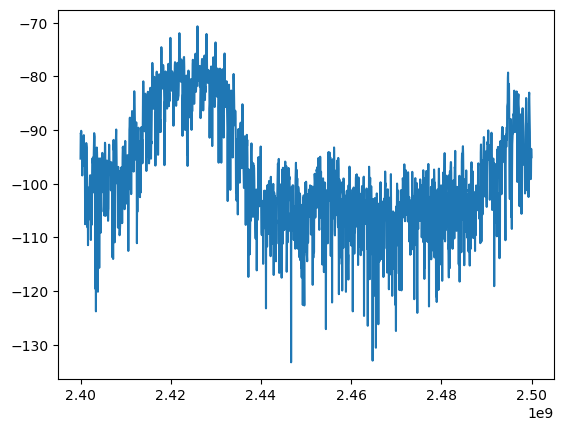

Pass


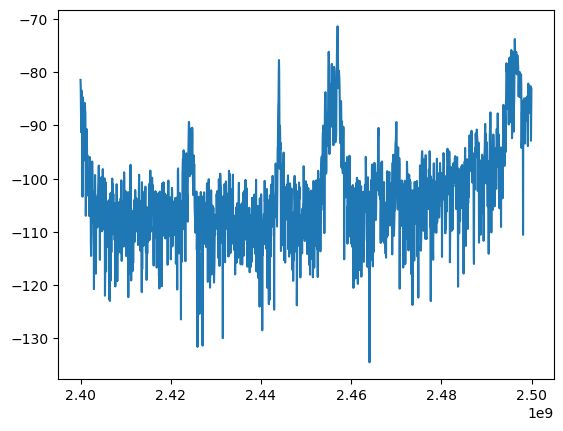

Pass


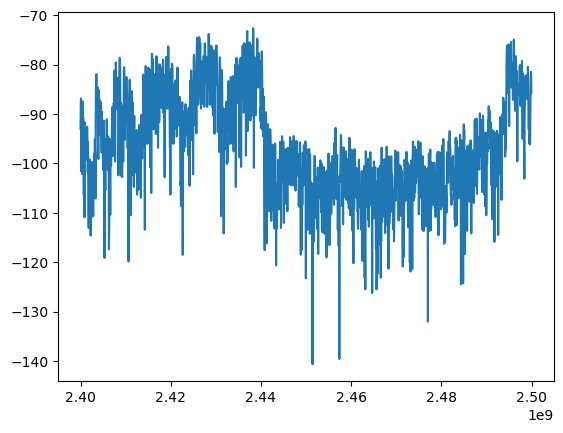

Pass


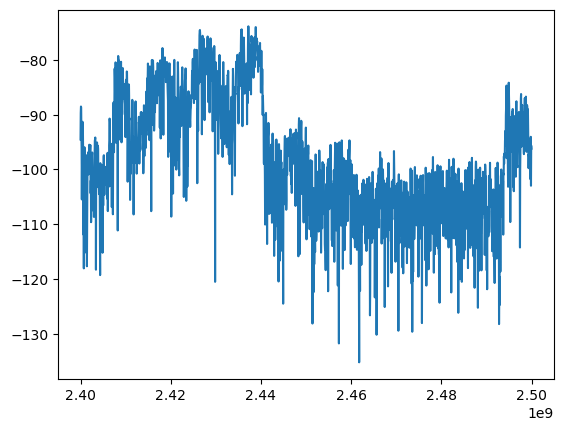

Pass


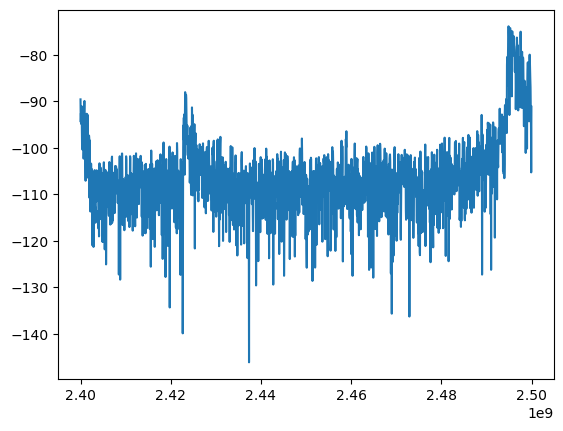

Pass


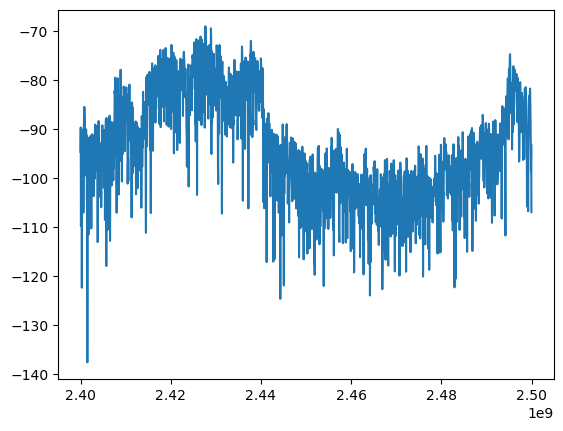

Pass


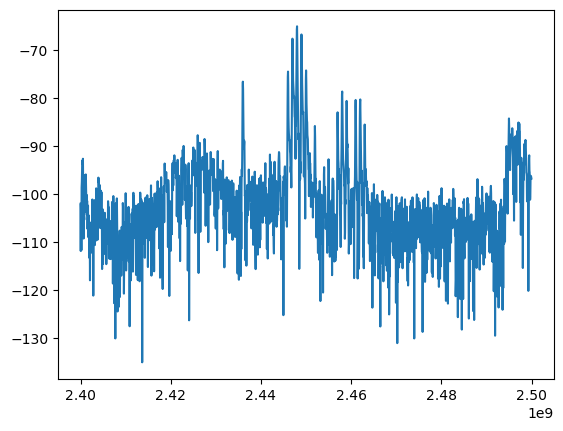

Pass


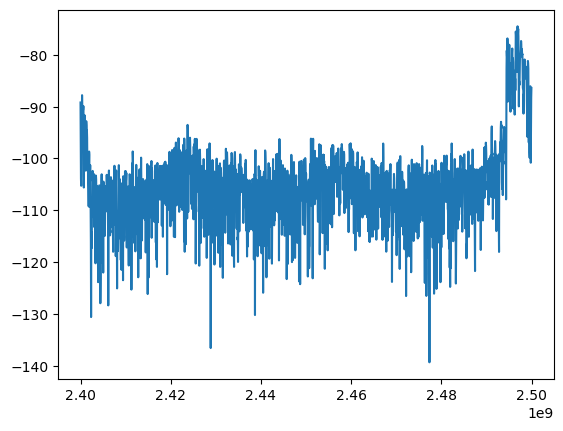

Pass


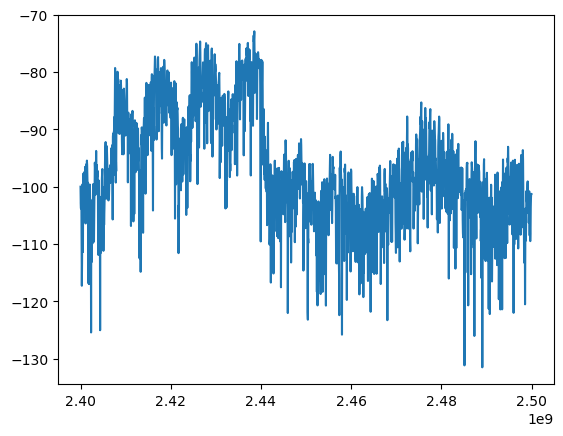

Pass


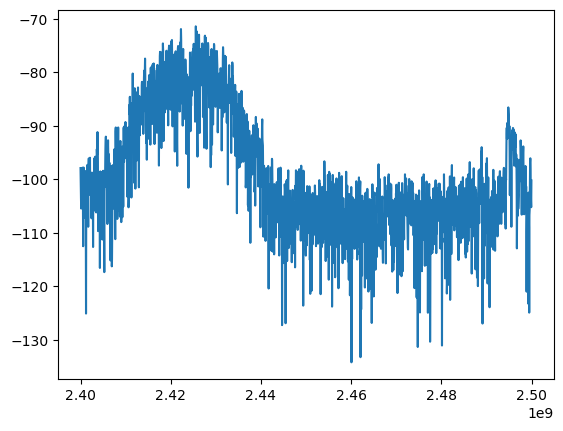

Pass


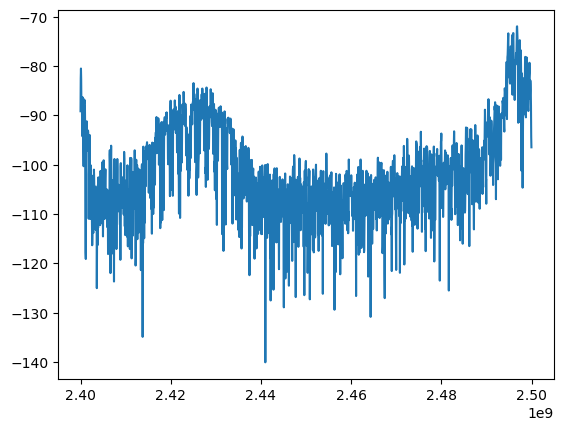

Pass


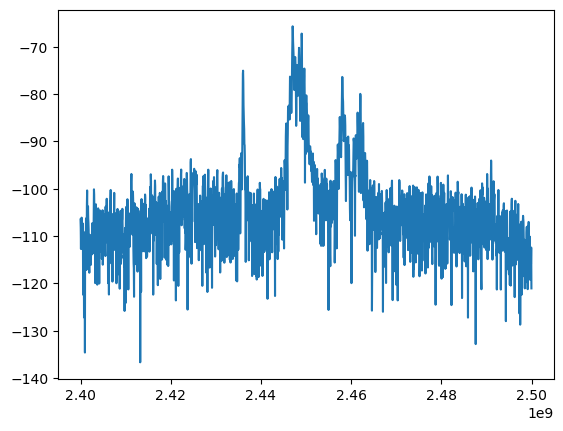

Pass


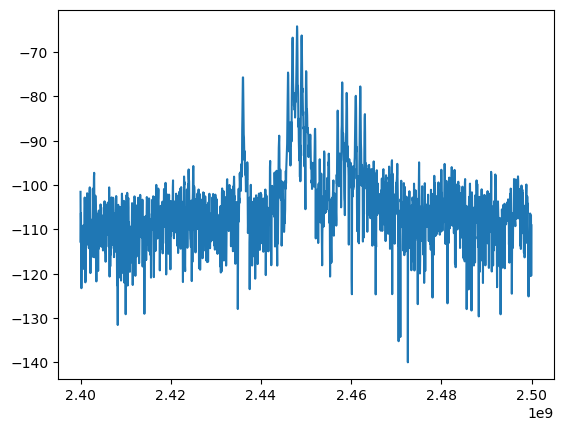

Pass


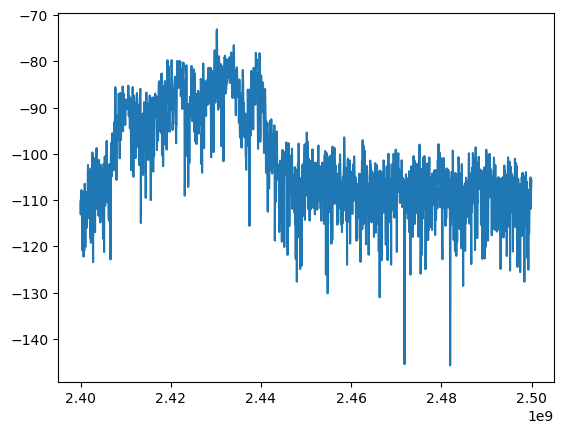

Pass


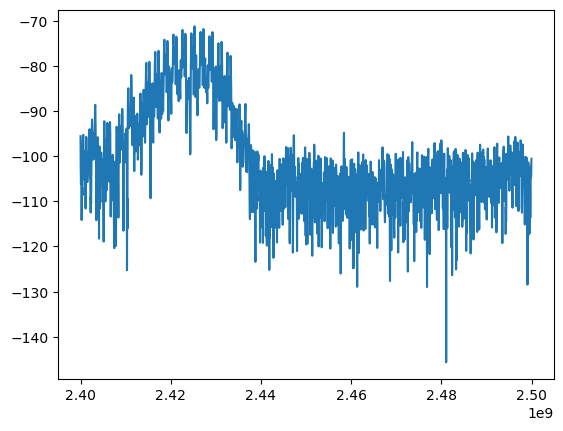

Pass


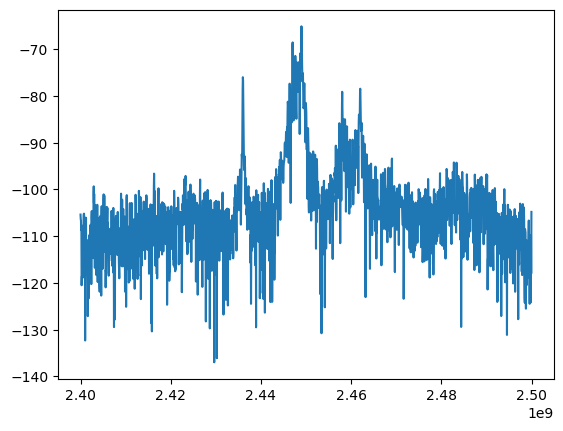

Pass


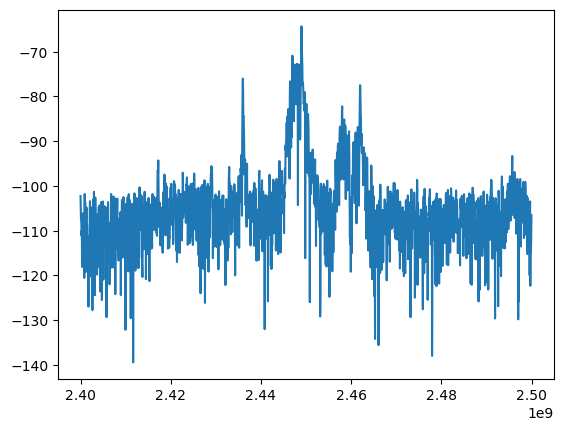

D

Pass


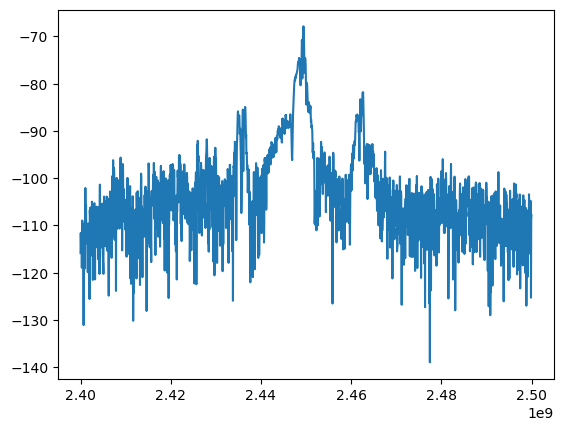

Pass


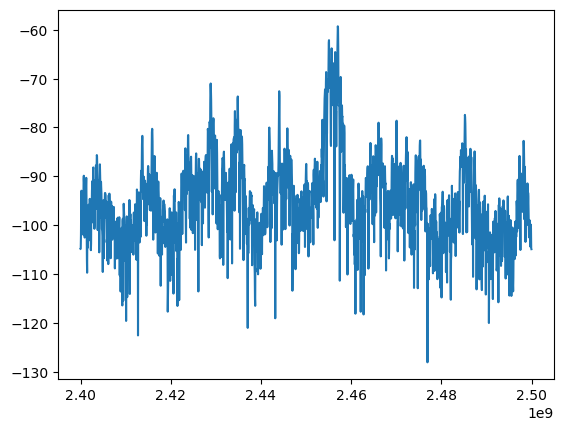

Pass


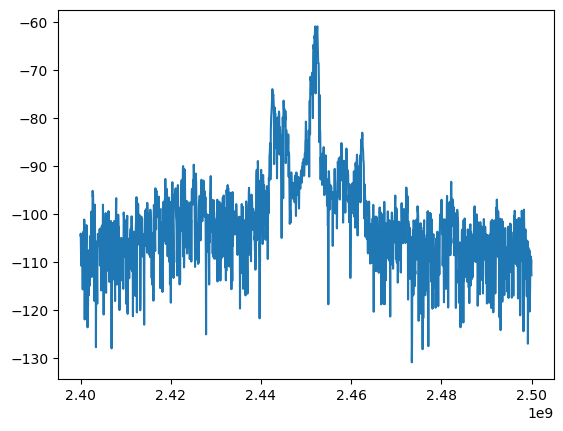

Pass


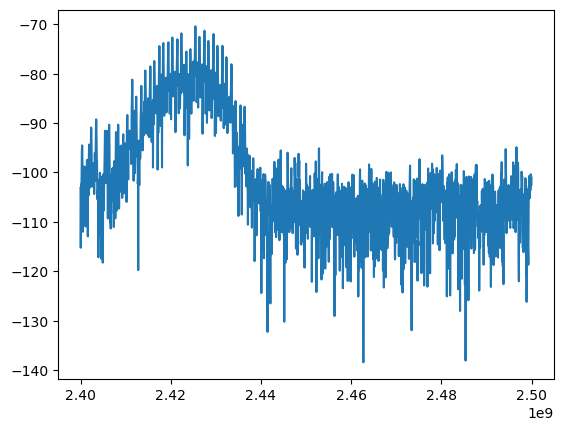

Pass


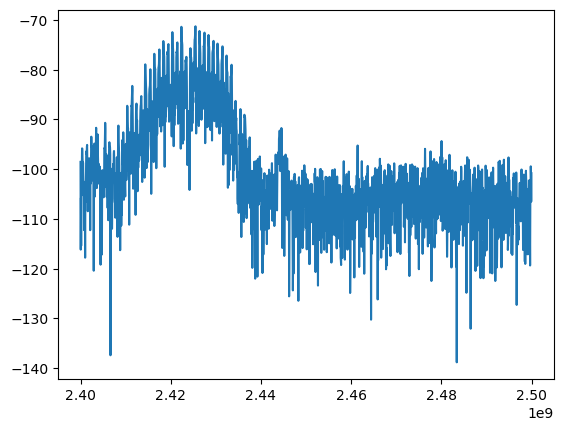

Pass


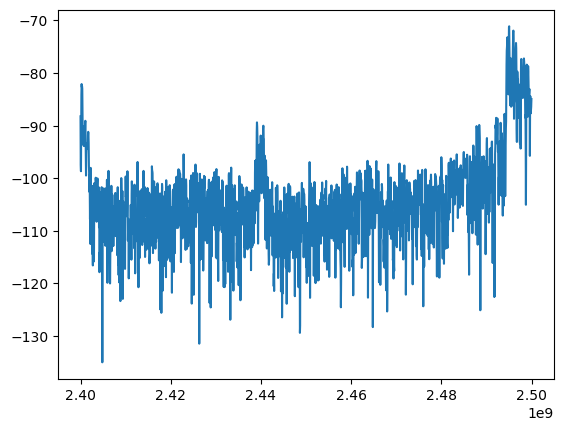

Pass


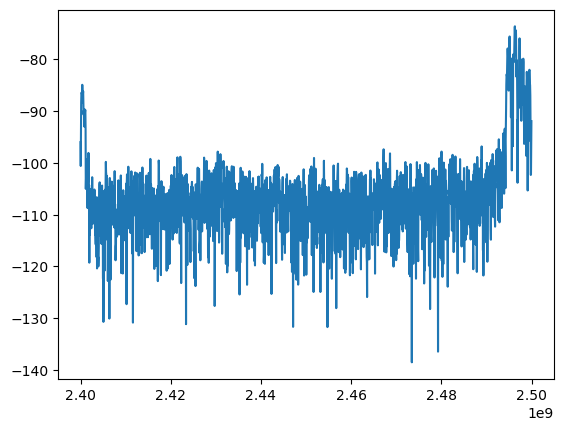

Pass


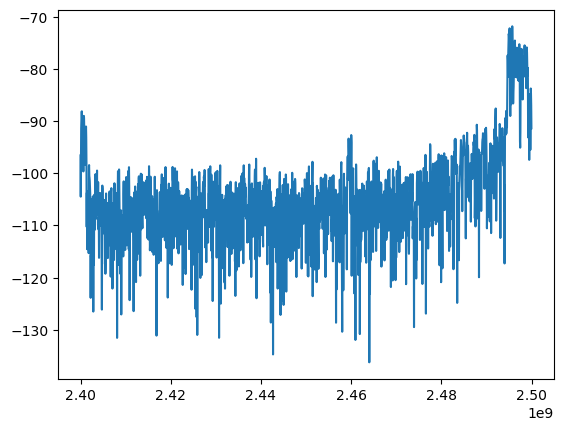

Pass


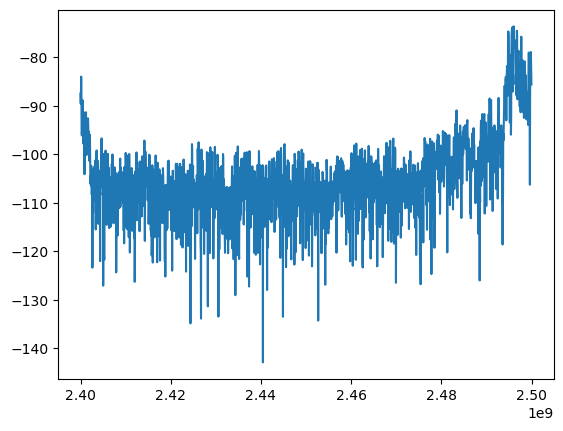

Pass


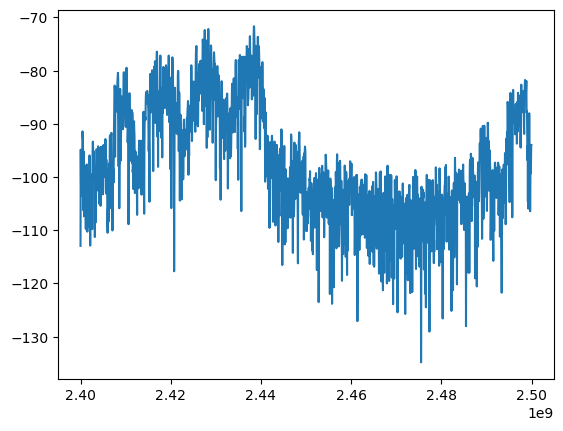

Pass


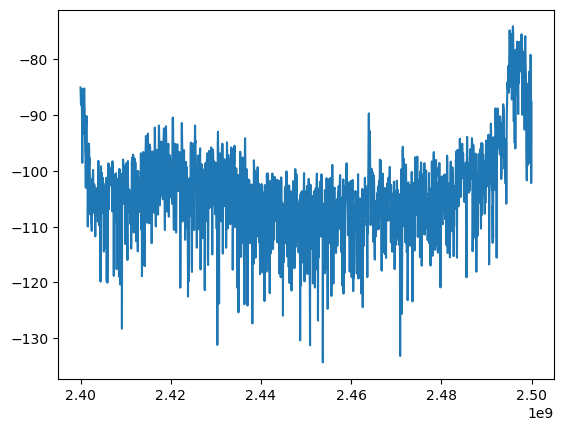

Pass


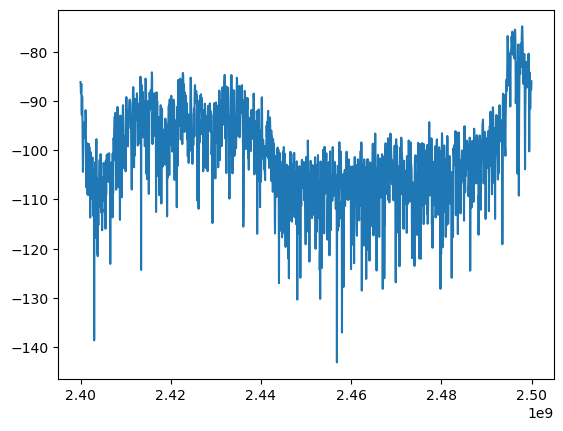

Pass


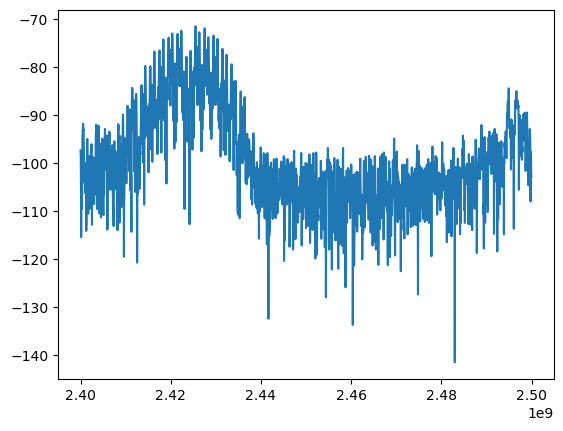

Pass


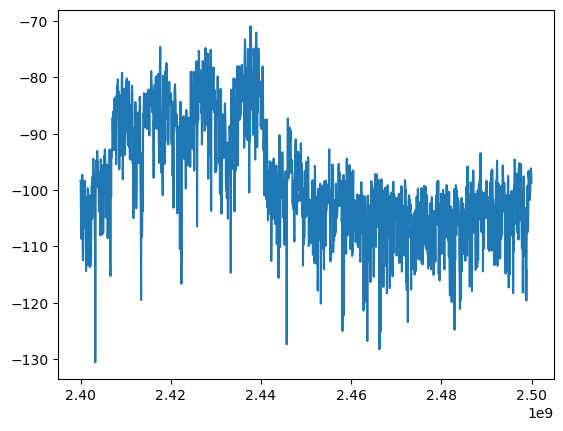

Pass


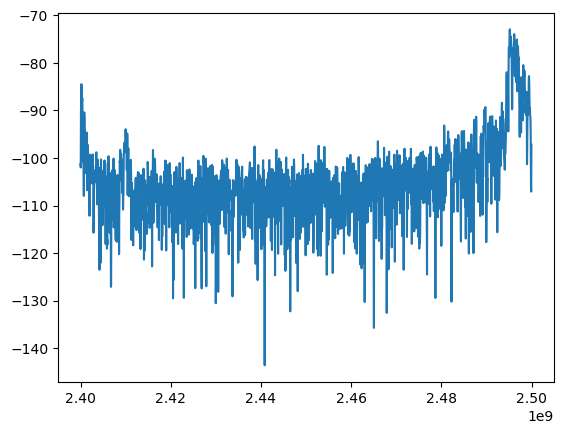

Pass


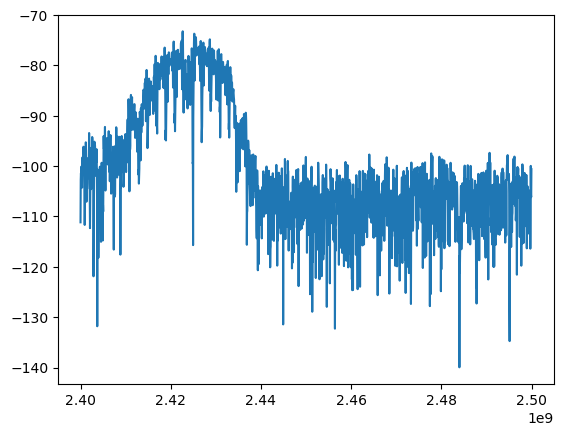

Pass


D

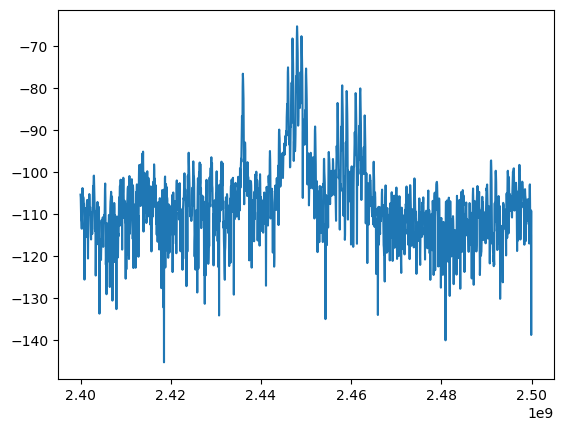

Pass


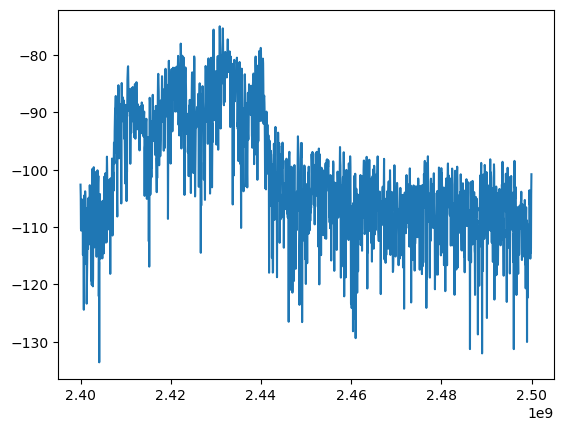

Pass


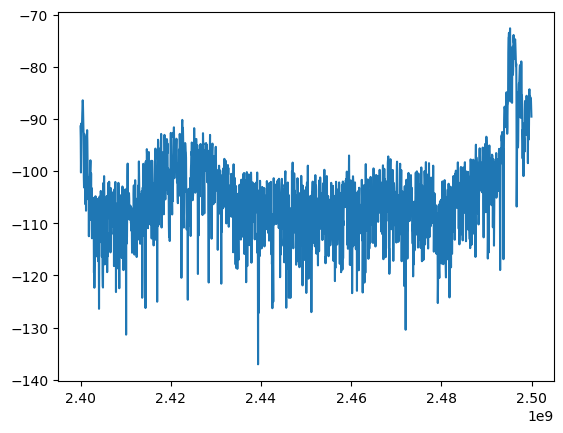

Pass


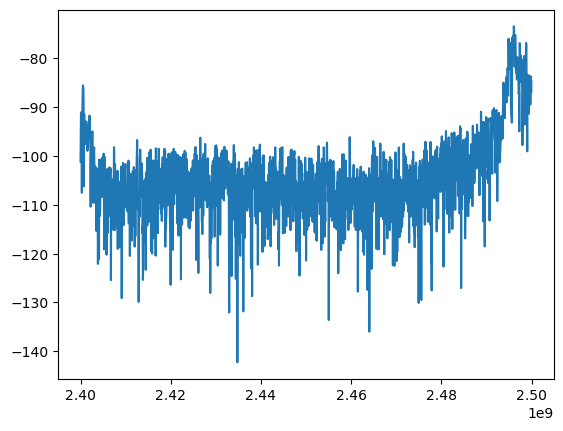

Pass


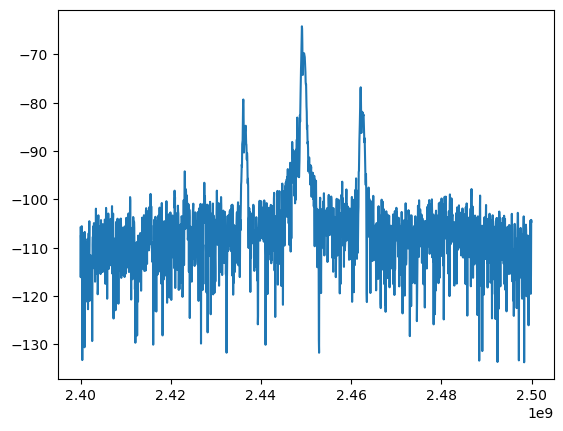

Pass


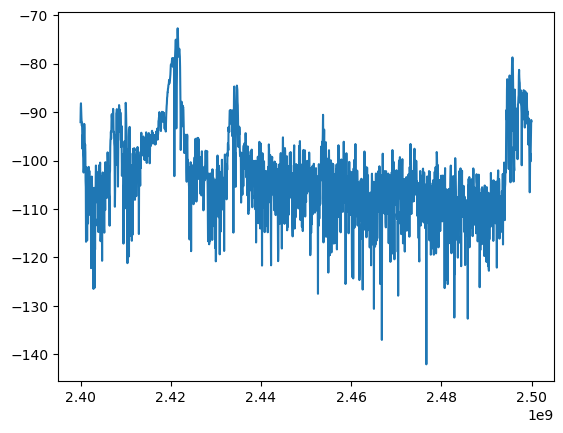

Pass


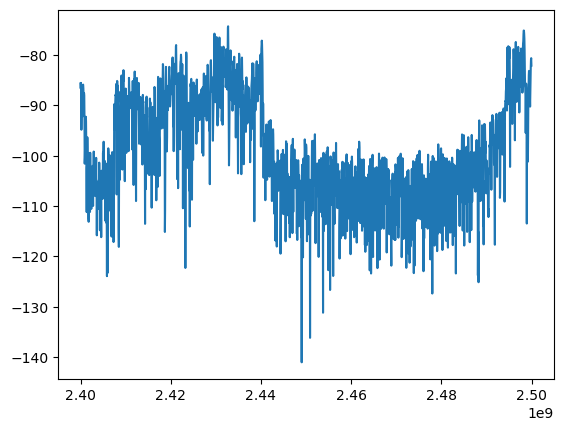

Pass


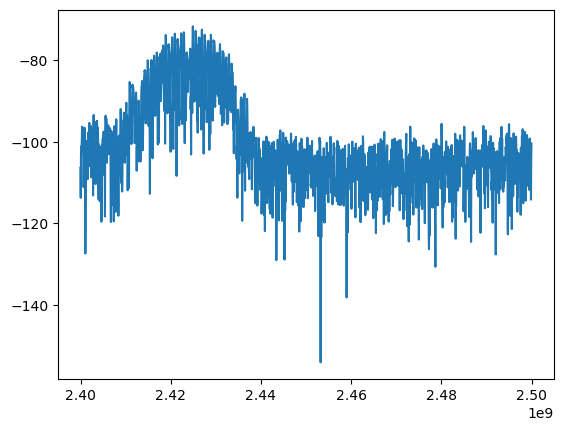

Pass


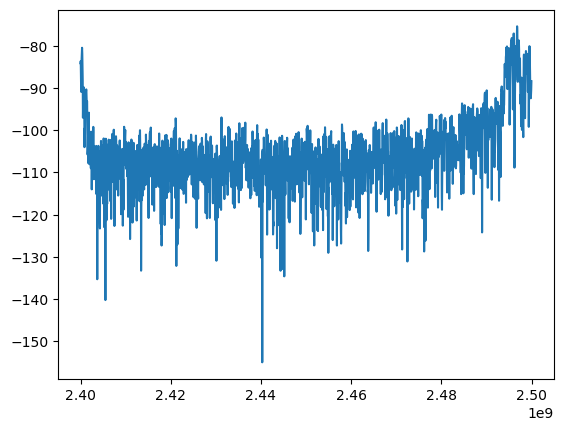

Pass


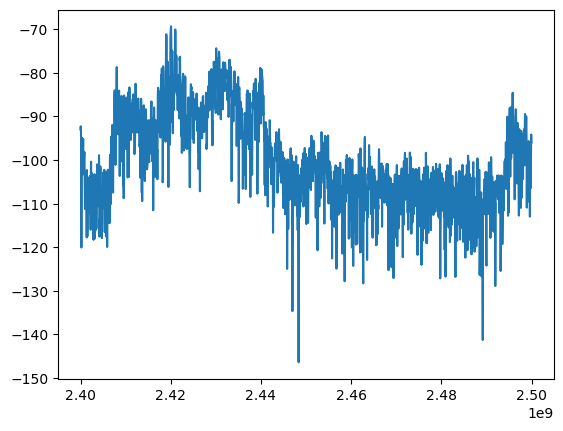

Pass


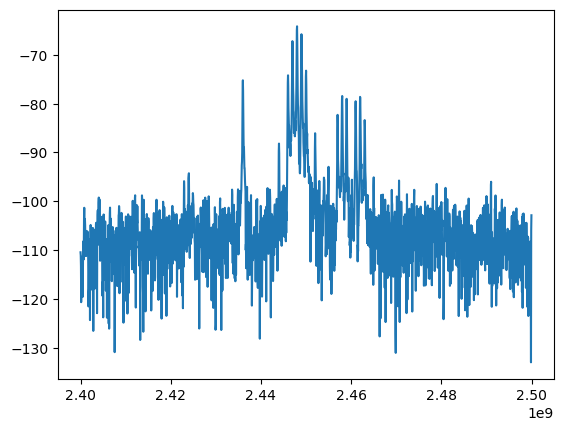

Pass


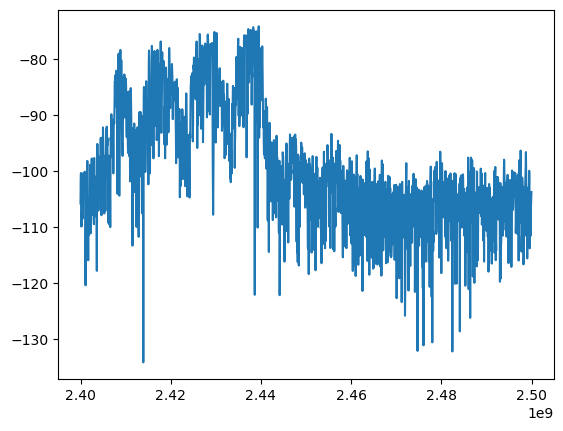

Pass


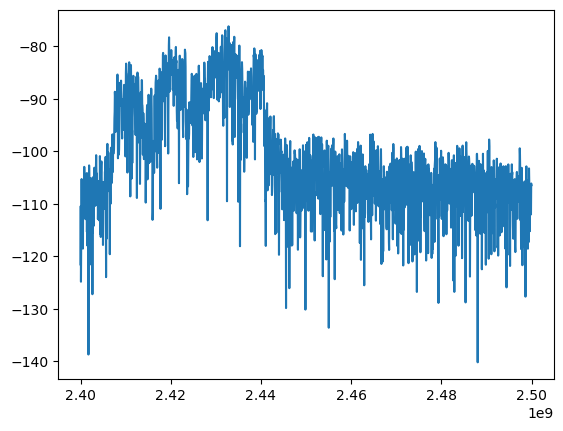

Pass


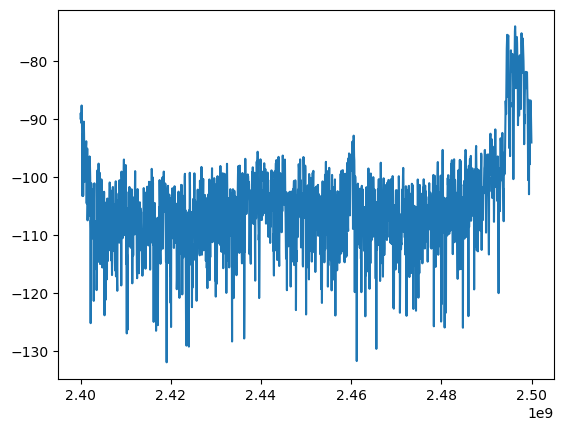

Pass


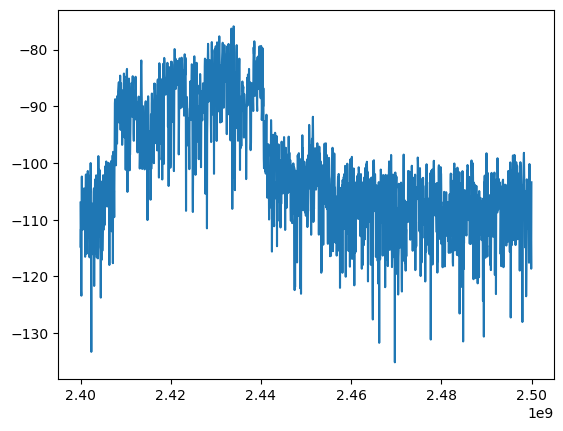

Pass


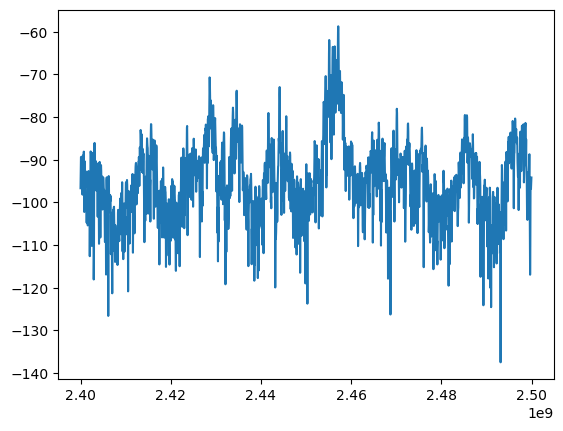

Pass


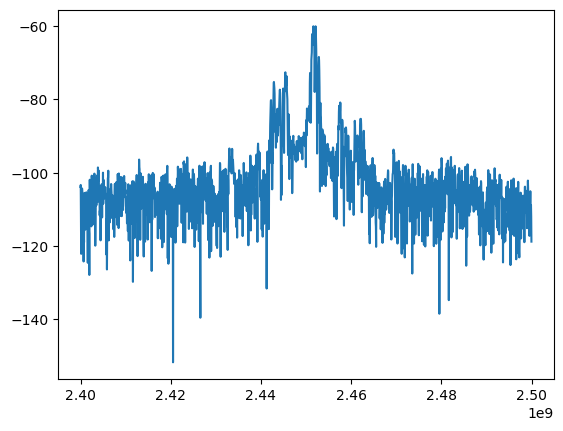

Pass


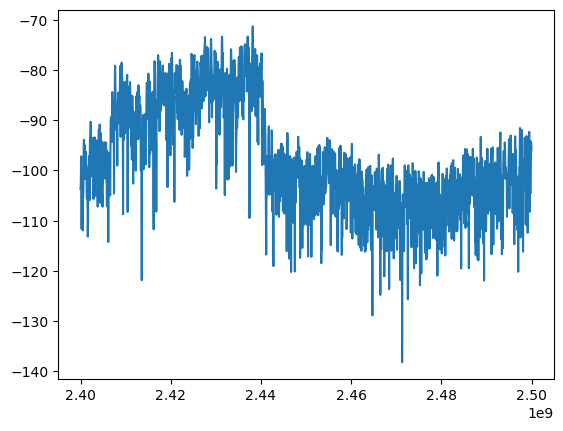

Pass


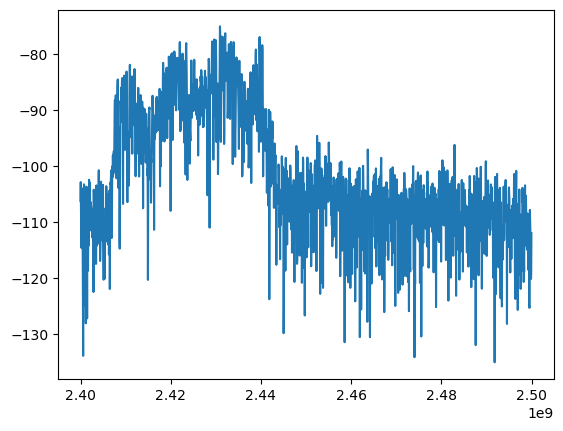

Pass


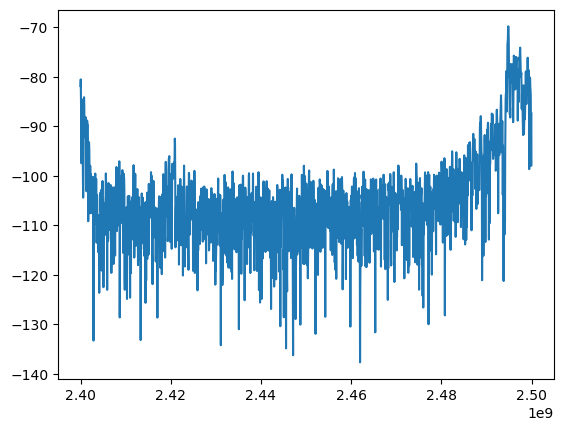

Pass


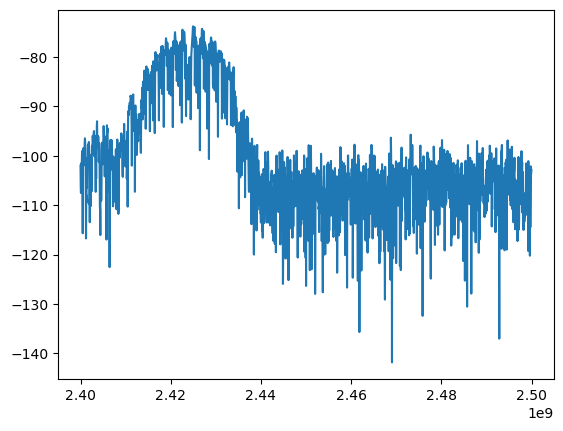

Pass


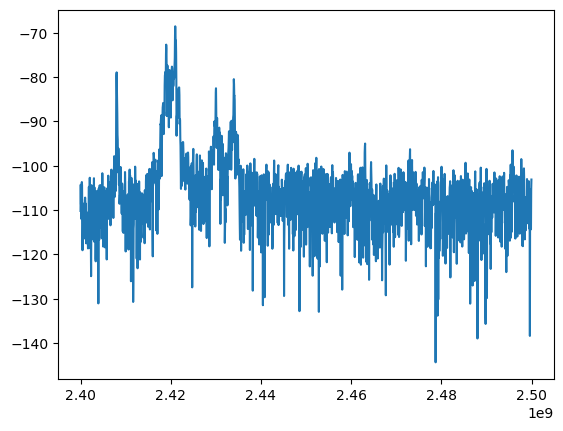

Pass


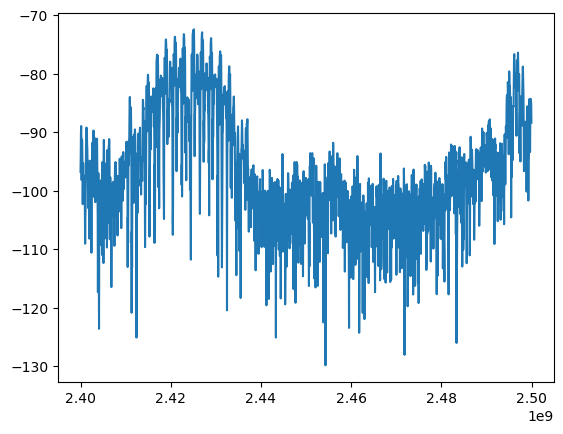

Pass


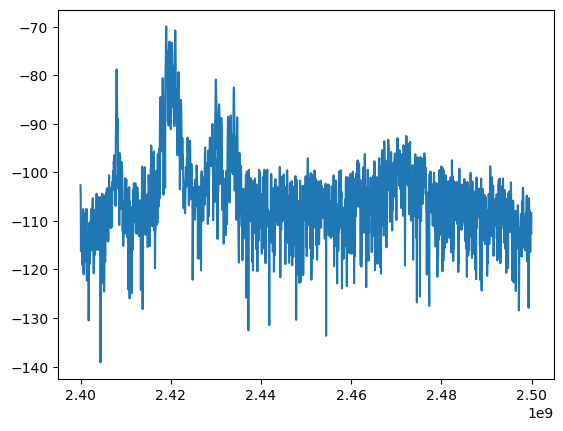

In [17]:
try:
        z=1
        PSD= []
        for i in tqdm(range(collects)):
            iq_data = receive_iq_data(center_freq=2.425e9)
            iq_data_2 = receive_iq_data(center_freq=2.475e9)          
            
            iq_data_total = np.concatenate((iq_data,iq_data_2))
            
            event, frequency = calculate_psd(iq_data_total, center_freq=2.45e9)
           
            
            #print(len(frequency))
            #print(frequency)
            
            
            #print(len(frequency))
            #print(frequency)
        
            if ((event_detector(event, -80))):
                 #print(len(frequency))
                 #print(len(x))
                 np.save(f"test_over_the_air_{z}.npy", event.astype(np.float32))
                 print("Pass")
                 z+=1
                 plt.plot(frequency, event)
                 plt.show()
            
        

except Exception as e:
    print(f"An error occurred: {e}")


# title